# Playing around with the notMNIST dataset

The following cell is the set of modules that is required. What is missing in the code they provided is that you need support for "pillow". So go ahead and install that too, if you don't want a stupid missing module error to ruin your flow later on.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline



First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


At this point, train_folders is a list of the directories that contain the images, as evident below...

In [4]:
train_folders

['./notMNIST_large/A',
 './notMNIST_large/B',
 './notMNIST_large/C',
 './notMNIST_large/D',
 './notMNIST_large/E',
 './notMNIST_large/F',
 './notMNIST_large/G',
 './notMNIST_large/H',
 './notMNIST_large/I',
 './notMNIST_large/J']

Now, to display one of these directories here, you do this...

Okay, I forgot how many there are, so letssay 20 of them

In [5]:
root, _, files = list(os.walk('./notMNIST_large/A'))[0]
for i in range(20):
    display(Image(os.path.join(root, files[i])))

Now, all the images in each of the directories are stacked into a 3d array, index [image_number, :, :] being one of the images. This ndarray object is pickled.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

train_datasets and test_datasets hold the lists of the paths to the pickle files...

In [7]:
train_datasets

['./notMNIST_large/A.pickle',
 './notMNIST_large/B.pickle',
 './notMNIST_large/C.pickle',
 './notMNIST_large/D.pickle',
 './notMNIST_large/E.pickle',
 './notMNIST_large/F.pickle',
 './notMNIST_large/G.pickle',
 './notMNIST_large/H.pickle',
 './notMNIST_large/I.pickle',
 './notMNIST_large/J.pickle']

This is how you load a pickle file into a variable...
and then how to display twenty of those pickled images...

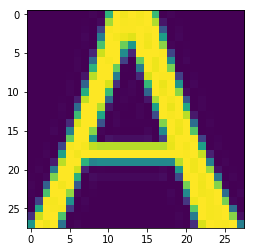

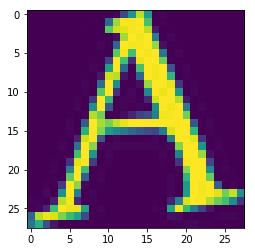

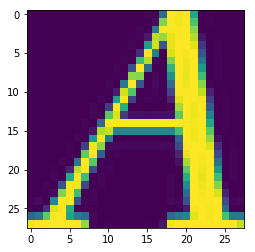

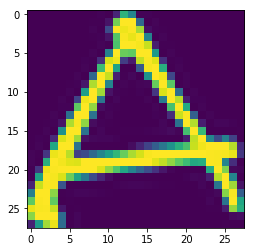

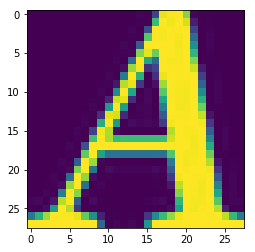

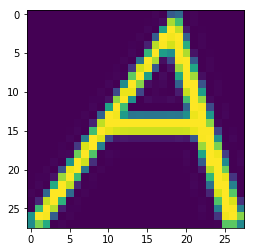

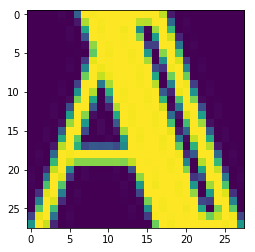

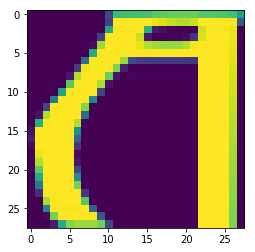

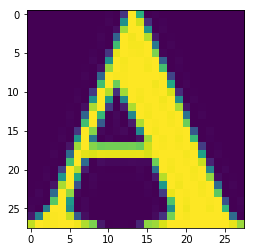

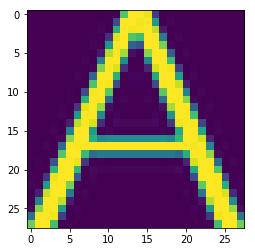

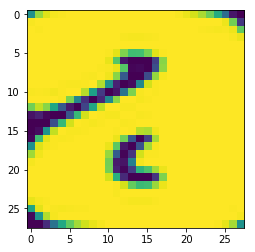

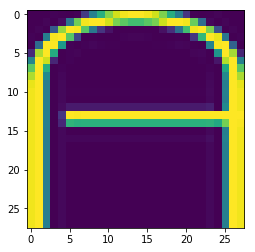

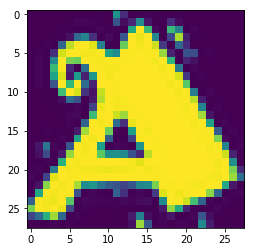

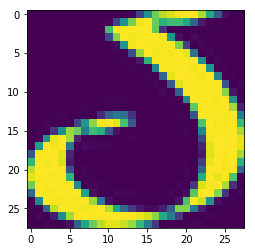

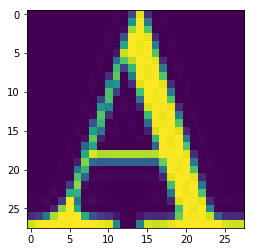

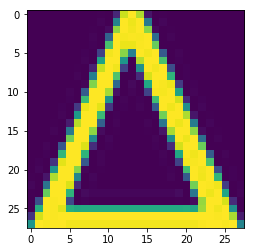

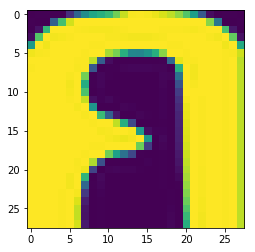

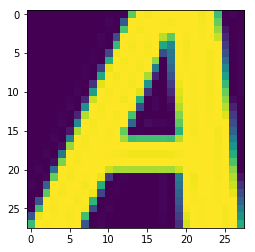

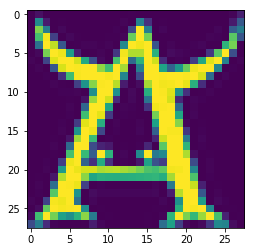

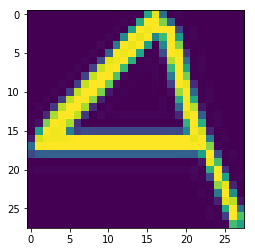

In [8]:
f = open(train_datasets[0], 'rb')
data = pickle.load(f)
for i in range(20):
    plt.imshow(data[i], interpolation='nearest')
    plt.show()
f.close()

Checking the number of images in each dataset...

In [9]:
for pickle_file in train_datasets+test_datasets:
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
        print(pickle_file, " contains ", data.shape[0], " images")

./notMNIST_large/A.pickle  contains  52909  images
./notMNIST_large/B.pickle  contains  52911  images
./notMNIST_large/C.pickle  contains  52912  images
./notMNIST_large/D.pickle  contains  52911  images
./notMNIST_large/E.pickle  contains  52912  images
./notMNIST_large/F.pickle  contains  52912  images
./notMNIST_large/G.pickle  contains  52912  images
./notMNIST_large/H.pickle  contains  52912  images
./notMNIST_large/I.pickle  contains  52912  images
./notMNIST_large/J.pickle  contains  52911  images
./notMNIST_small/A.pickle  contains  1872  images
./notMNIST_small/B.pickle  contains  1873  images
./notMNIST_small/C.pickle  contains  1873  images
./notMNIST_small/D.pickle  contains  1873  images
./notMNIST_small/E.pickle  contains  1873  images
./notMNIST_small/F.pickle  contains  1872  images
./notMNIST_small/G.pickle  contains  1872  images
./notMNIST_small/H.pickle  contains  1872  images
./notMNIST_small/I.pickle  contains  1872  images
./notMNIST_small/J.pickle  contains  187

Checking for data overlap between the datasets:

In [10]:
# Embarassingly naive as of now. TODO is to use hashing. Hash using a random small subset of the pixels.

# To save myself from embarassment, this cell is commented out as of now. 
# The results showed a hint above 1 percent of overlap.

"""
for i in range(10):
    print("-----------------Running for label {label}------------------".format(label=i))
    with open(train_datasets[i], 'rb') as f_tr, open(test_datasets[i], 'rb') as f_te:
        tr_ds = pickle.load(f_tr)
        te_ds = pickle.load(f_te)
        
        count = 0
        i = 0
        j = 0
        for image in tr_ds:
            #print("POOP")
            i += 1
            j = 0
            for another_image in te_ds:
                j += 1
                if (image == another_image).all():
                    count += 1
                    if count % 100 == 0:
                        print("{prog} percent done, {bad} percent overlap".format(
                            prog=(i/tr_ds.shape[0])*100,
                            bad=count/i*100))
                    
        print("Label: {label}, Overlap: {overlap}".format(label=i, overlap=count))
"""


'\nfor i in range(10):\n    print("-----------------Running for label {label}------------------".format(label=i))\n    with open(train_datasets[i], \'rb\') as f_tr, open(test_datasets[i], \'rb\') as f_te:\n        tr_ds = pickle.load(f_tr)\n        te_ds = pickle.load(f_te)\n        \n        count = 0\n        i = 0\n        j = 0\n        for image in tr_ds:\n            #print("POOP")\n            i += 1\n            j = 0\n            for another_image in te_ds:\n                j += 1\n                if (image == another_image).all():\n                    count += 1\n                    if count % 100 == 0:\n                        print("{prog} percent done, {bad} percent overlap".format(\n                            prog=(i/tr_ds.shape[0])*100,\n                            bad=count/i*100))\n                    \n        print("Label: {label}, Overlap: {overlap}".format(label=i, overlap=count))\n'

Also create a validation dataset for hyperparameter tuning:

In [11]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match:

In [12]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
print("Done!")

Done!


Checking to see if the randomized data is still good:

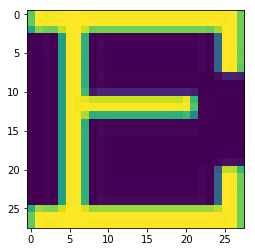

Label:  4


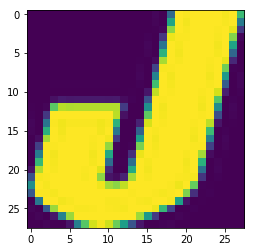

Label:  9


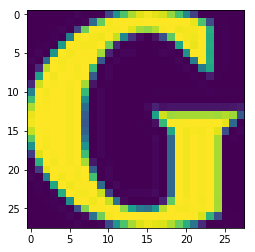

Label:  6


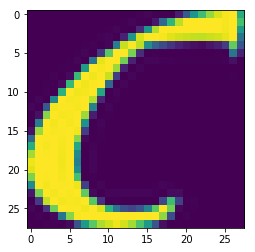

Label:  2


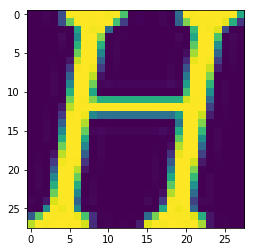

Label:  7


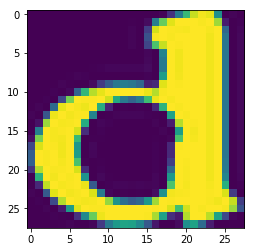

Label:  3


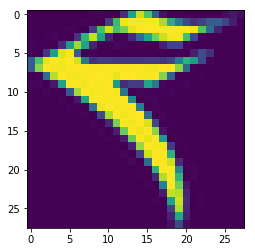

Label:  5


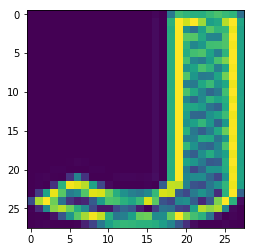

Label:  9


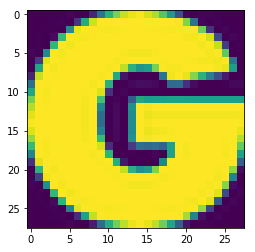

Label:  6


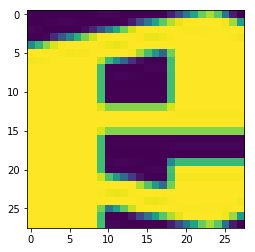

Label:  4


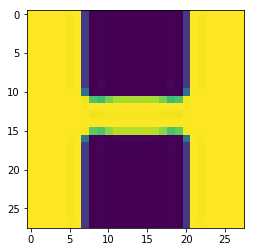

Label:  7


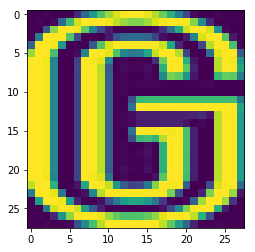

Label:  6


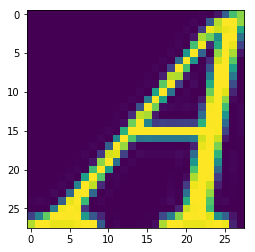

Label:  0


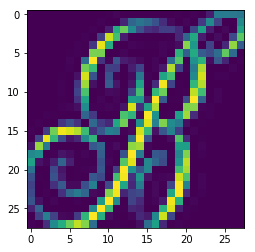

Label:  1


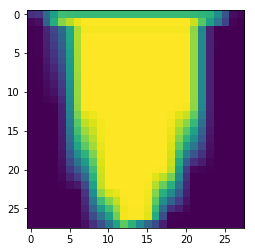

Label:  8


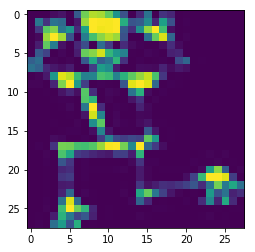

Label:  0


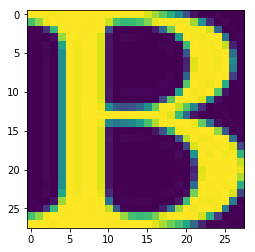

Label:  1


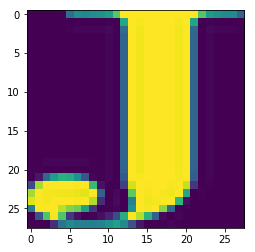

Label:  9


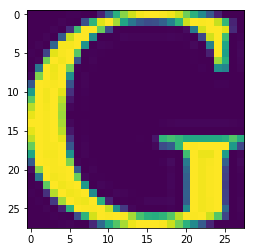

Label:  6


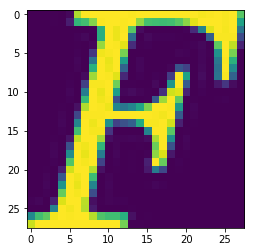

Label:  5


In [13]:
for i in range(20):
    plt.imshow(train_dataset[i], interpolation='nearest')
    plt.show()
    print("Label: ", train_labels[i])

Pickling everything...

In [14]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
  print("Done!")

except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    


Done!


The pickle filesize is...

In [15]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size//1000000, "MB")

Compressed pickle size: 690 MB


Using "sklearn.linear_model.LogisticRegression"

In [23]:
number_of_training_images_to_use = 200000 # max = 200000

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
# print('Training set', train_dataset.shape, train_labels.shape)
# print('Validation set', valid_dataset.shape, valid_labels.shape)
# print('Test set', test_dataset.shape, test_labels.shape)

def flattify(some_ndarray):
    """This method converts each of the pictures to a 1D array of the pixels"""
    return some_ndarray.reshape(some_ndarray.shape[0], -1)


classifier = LogisticRegression(verbose=1,
                                n_jobs=-1,
                                solver='sag',
                                max_iter=200)

print("Starting fitting...")
classifier.fit(flattify(train_dataset[:number_of_training_images_to_use]), 
                        train_labels[:number_of_training_images_to_use])

print("Fitting finished and score on test dataset is {}".format(
    classifier.score(flattify(test_dataset), test_labels)
    )
)

Starting fitting...
convergence after 50 epochs took 127 seconds
convergence after 65 epochs took 163 seconds
convergence after 69 epochs took 174 seconds
convergence after 70 epochs took 180 seconds
convergence after 53 epochs took 135 seconds
convergence after 61 epochs took 156 seconds
convergence after 59 epochs took 153 seconds
convergence after 81 epochs took 200 seconds
convergence after 79 epochs took 155 seconds
convergence after 62 epochs took 104 seconds
Fitting finished and score on test dataset is 0.8913


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.2min finished
